# Use TLS with Let's Encrypt

Use a dynamic public IP address to create an HTTPS ingress controller on Azure Kubernetes Service

## Create an Ingress controller

To create the ingress controller, use the helm command to install nginx-ingress. 

In [1]:
helm install nginx-ingress ingress-nginx/ingress-nginx \
    --set controller.replicaCount=2 \
    --set controller.nodeSelector."beta\.kubernetes\.io/os"=linux \
    --set defaultBackend.nodeSelector."beta\.kubernetes\.io/os"=linux \
    --set controller.admissionWebhooks.patch.nodeSelector."beta\.kubernetes\.io/os"=linux

NAME: nginx-ingress
LAST DEPLOYED: Fri Jul  9 08:50:48 2021
NAMESPACE: default
STATUS: deployed
REVISION: 1
TEST SUITE: None
NOTES:
The ingress-nginx controller has been installed.
It may take a few minutes for the LoadBalancer IP to be available.
You can watch the status by running 'kubectl --namespace default get services -o wide -w nginx-ingress-ingress-nginx-controller'

An example Ingress that makes use of the controller:

  apiVersion: networking.k8s.io/v1beta1
  kind: Ingress
  metadata:
    annotations:
      kubernetes.io/ingress.class: nginx
    name: example
    namespace: foo
  spec:
    rules:
      - host: www.example.com
        http:
          paths:
            - backend:
                serviceName: exampleService
                servicePort: 80
              path: /
    # This section is only required if TLS is to be enabled for the Ingress
    tls:
        - hosts:
            - www.example.com
          secretName: example-tls

If TLS is enabled for the Ingress, a 

Watch the status of the controller using:

In [ ]:
kubectl --namespace default get services -o wide -w nginx-ingress-ingress-nginx-controller

NAME                                     TYPE           CLUSTER-IP     EXTERNAL-IP    PORT(S)                      AGE     SELECTOR
nginx-ingress-ingress-nginx-controller   LoadBalancer   10.0.118.237   52.224.31.58   80:32603/TCP,443:32459/TCP   2m24s   app.kubernetes.io/component=controller,app.kubernetes.io/instance=nginx-ingress,app.kubernetes.io/name=ingress-nginx


"nginx-ingress-ingress-nginx-controller" is the name of the exernal IP address created.

## Add a record to DNS zone 

configure an FQDN-- Fully Qualified Domain Name -- for the ingress controller IP address. 

In [1]:
# Public IP address of your ingress controller
IP="52.224.31.58"

# Name to associate with public IP address
DNSNAME="ecl-ingress"

# Get the resource-id of the public ip
PUBLICIPID=$(az network public-ip list --query "[?ipAddress!=null]|[?contains(ipAddress, '52.224.31.58')].[id]" --output tsv)

# Update public ip address with DNS name
az network public-ip update --ids $PUBLICIPID --dns-name "ecl-ingress"

# Display the FQDN
az network public-ip show --ids $PUBLICIPID --query "[dnsSettings.fqdn]" --output tsv

{
  "ddosSettings": null,
  "deleteOption": null,
  "dnsSettings": {
    "domainNameLabel": "ecl-ingress",
    "fqdn": "ecl-ingress.eastus.cloudapp.azure.com",
    "reverseFqdn": null
  },
  "etag": "W/\"f8bf885e-23f8-49c9-89b5-479f0a5ceece\"",
  "extendedLocation": null,
  "id": "/subscriptions/49219efc-701f-4c7e-a2ac-c600308a69e3/resourceGroups/mc_aks-1nodepool-sa-amy_aks-1nodepool-sa-amy-eastus_eastus/providers/Microsoft.Network/publicIPAddresses/kubernetes-a1c6599063c0f48f88f4b7491cedff47",
  "idleTimeoutInMinutes": 4,
  "ipAddress": "52.224.31.58",
  "ipConfiguration": {
    "etag": null,
    "id": "/subscriptions/49219efc-701f-4c7e-a2ac-c600308a69e3/resourceGroups/mc_aks-1nodepool-sa-amy_aks-1nodepool-sa-amy-eastus_eastus/providers/Microsoft.Network/loadBalancers/kubernetes/frontendIPConfigurations/a1c6599063c0f48f88f4b7491cedff47",
    "name": null,
    "privateIpAddress": null,
    "privateIpAllocationMethod": null,
    "provisioningState": null,
    "publicIpAddress": null,
  

## Install cert-manager

Retrieve and configure certificates for HTTPS using cert-manager, which provides automatic Lets Encrypt certificate generation and management functionality.

Install cert-manager controller:

In [2]:
# Add the Jetstack Helm repository
helm repo add jetstack https://charts.jetstack.io

# Update your local Helm chart repository cache
helm repo update

# Install the cert-manager Helm chart
helm install cert-manager jetstack/cert-manager \
  --set installCRDs=true \
  --set nodeSelector."kubernetes\.io/os"=linux \
  --set webhook.nodeSelector."kubernetes\.io/os"=linux \
  --set cainjector.nodeSelector."kubernetes\.io/os"=linux

"jetstack" already exists with the same configuration, skipping
Hang tight while we grab the latest from your chart repositories...
...Successfully got an update from the "jetstack" chart repository
...Successfully got an update from the "ingress-nginx" chart repository
...Successfully got an update from the "haproxy-ingress" chart repository
...Successfully got an update from the "hpcc" chart repository
...Successfully got an update from the "nginx-stable" chart repository
Update Complete. ⎈Happy Helming!⎈
Error: cannot re-use a name that is still in use


: 1

## Create a CA cluster issuer

In order to begin issuing certificates, you will need to set up a ClusterIssuer.  ClusterIssuer works across all namespaces.  Create a cluster issuer, such as *cluster-issuer.yaml*, using the following example manifest. Update the email address with a valid address from your organization:

In [ ]:
nano cluster-issuer.yaml

In [ ]:
apiVersion: cert-manager.io/v1
kind: ClusterIssuer
metadata:
  name: letsencrypt
spec:
  acme:
    server: https://acme-v02.api.letsencrypt.org/directory
    email: amy.ma5656@gmail.com # replace with valid email
    privateKeySecretRef:
      name: letsencrypt
    solvers:
    - http01:
        ingress:
          class: nginx
          podTemplate:
            spec:
              nodeSelector:
                "kubernetes.io/os": linux

Create the issuer:

In [ ]:
kubectl apply -f cluster-issuer.yaml

The output should look like this:

In [ ]:
clusterissuer.cert-manager.io/letsencrypt created

## Run applications

An ingress controller and a certificate management solution have been configured, applications can be run.  Create a file with the name "eclwatch.yaml"

In [ ]:
nano eclwatch.yaml

In [ ]:
apiVersion: networking.k8s.io/v1
kind: Ingress
metadata:
  name: eclwatch-ingress
  annotations:
    kubernetes.io/ingress.class: nginx
spec:
  rules:
  -  http:
      paths:
      - path: /
        pathType: Prefix
        backend:
         service:
           name: eclwatch
           port:
             number: 8010

* ClusterIP service type: Exposes the service on a cluster-internal IP. Choosing this value makes the service only reachable from within the cluster.  The service will be made publicly available in the next step, by creating a kubernetes ingress resource.
* port 8010 corresponds to service eclwatch.

Run the application using:

In [ ]:
kubectl apply -f eclwatch.yaml

The output should be similar to:

In [ ]:
ingress.networking.k8s.io/eclwatch-ingress configured

## Create an Ingress route

The application created previously is now running on your kubernetes cluster.  Since it is configured with a service of type "ClusterIP" and aren't accessible from the internet. To make the service publicly available, create a Kubernetes ingress resource. The ingress resource configures the rules that route traffic to one of the two applications.

* Refer to a previous step where FDQN was made for the ingress controller IP address.  It will be the host in the yaml file shown below.
The DNS name you specified is used in the FQDN.
**example:**
DNS_NAME.eastus.cloudapp.azure.com
**In this case, it is:**
ecl-aks-ingress.eastus.cloudapp.azure.com

Display your FQDN using:

In [29]:
az network public-ip show --ids $PUBLICIPID --query "[dnsSettings.fqdn]" --output tsv

ecl-ingress.eastus.cloudapp.azure.com


Create a file for the Ingress route, named "eclwatch-ingres-route.yaml"

In [ ]:
apiVersion: networking.k8s.io/v1
kind: Ingress
metadata:
  name: eclwatch-ingress
  annotations:
    kubernetes.io/ingress.class: nginx
    nginx.ingress.kubernetes.io/rewrite-target: /$1
    nginx.ingress.kubernetes.io/use-regex: "true"
    cert-manager.io/cluster-issuer: letsencrypt
spec:
  tls:
  - hosts:
    - ecl-ingress.eastus.cloudapp.azure.com
    secretName: tls-secret
  rules:
  - host: ecl-ingress.eastus.cloudapp.azure.com
    http:
      paths:
      - path: /(/|$)(.*)
        pathType: Prefix
        backend:
          service:
            name: eclwatch
            port:
              number: 8010

Save the file, then create the ingress resource using the kubectl apply command.

In [ ]:
kubectl apply -f eclwatch-ingress-route.yaml 

The output should look like:

In [ ]:
ingress.networking.k8s.io/eclwatch-ingress configured
ingress.networking.k8s.io/eclwatch-ingress-static created

## Verify that an object has been created

Next, a certificate resource must be created. The certificate resource defines the desired X.509 certificate.  Cert-manager has automatically created a certificate object for you using ingress-shim, which is automatically deployed with cert-manager since v0.2.2.
* To verify that the certificate was created successfully, use the command below. READY must be True:

In [30]:
 kubectl get certificate

NAME         READY   SECRET       AGE
tls-secret   True    tls-secret   5s


In [12]:
# Example Output:
NAME         READY   SECRET       AGE
tls-secret   True    tls-secret   11m

bash: Example: command not found
bash: NAME: command not found
bash: tls-secret: command not found


: 127

## Test the Ingress Configuration.

Open a web browser to the FQDN created previously.   Notice you are redirect to use HTTPS and the certificate is trusted and the demo application is shown in the web browser

Open web browser: **https://ecl-ingress.eastus.cloudapp.azure.com**

On the upper left corner, connection displays 'secure'. The certificate is valid.

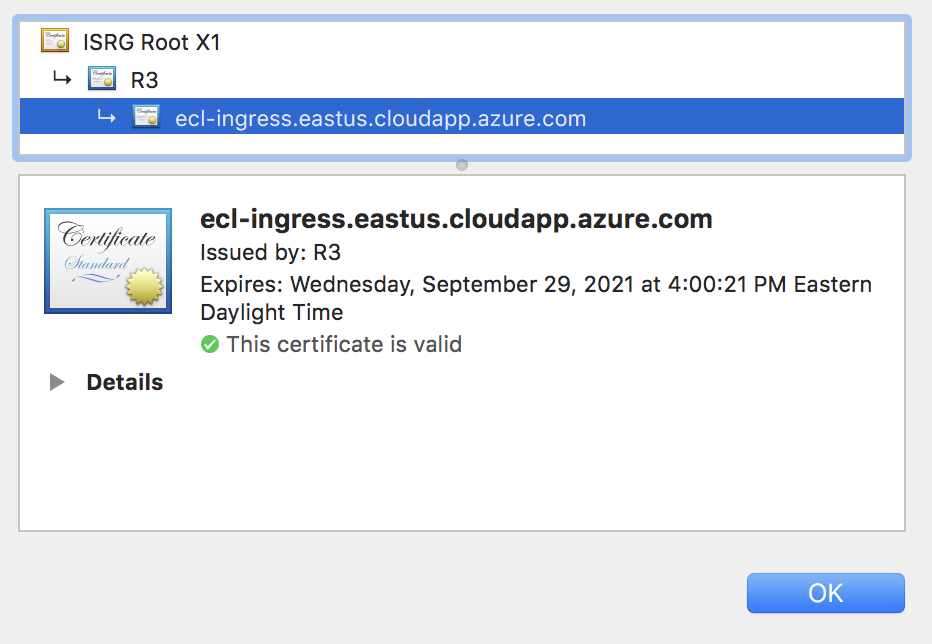

## Clean up resources

To delete the cluster issuer:

In [ ]:
kubectl delete -f cluster-issuer.yaml

List the Helm releases with the helm list command. Look for charts named nginx and cert-manager:

In [ ]:
helm list

In [ ]:
# Example output of "helm list"
NAME                    NAMESPACE       REVISION        UPDATED                                 STATUS          CHART                   APP VERSION
cert-manager            DEFAULT         1               2020-01-15 10:23:36.515514 -0600 CST    deployed        cert-manager-v0.13.0    v0.13.0    
nginx                   DEFAULT         1               2020-01-15 10:09:45.982693 -0600 CST    deployed        nginx-ingress-1.29.1    0.27.0  

Uninstall the releases with the helm uninstall command. The following example uninstalls the NGINX ingress and cert-manager deployments.

In [ ]:
$ helm uninstall cert-manager nginx 

release "cert-manager" uninstalled
release "nginx" uninstalled

Remove the application:

In [ ]:
kubectl delete -f eclwatch.yaml

Remove the ingress route that directed traffic to the sample apps:

In [ ]:
kubectl delete -f eclwatch-ingress-route.yaml